# 2. AutoEncoder 모델링
* 목적
    * 공정, 장비, unlabel 등 제품 생산 환경의 제약을 초월한 데이터의 특성을 추출하기 위한 AutoEncoder 모델을 생성


In [5]:
import pandas as pd
import numpy as np
import os
from datetime import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
from silence_tensorflow import silence_tensorflow
silence_tensorflow()
tf.debugging.set_log_device_placement(False)

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [6]:
BATCH_SIZE = 256
EPOCHS = 1000
learning_rate = 1e-7

In [7]:
def mad_score(points):
    """https://www.itl.nist.gov/div898/handbook/eda/section3/eda35h.htm """
    m = np.median(points)
    ad = np.abs(points - m)
    mad = np.median(ad)
    return 0.6745*ad / mad



### Load Datatset

In [9]:
X = pd.read_csv('./../dataset/unlabeled_X_scaled.csv')
train_cnt = int(len(X) * 0.7)
X_train = X.iloc[np.random.choice(X.index, train_cnt, replace=False), :]
X_valid = X.drop(X_train.index)

train_arr = X_train.values
valid_arr = X_valid.values

labeled_X = pd.read_csv('./../dataset/labeled_X_train_scaled.csv')
labeled_X_arr = labeled_X.values
train_arr = np.vstack((train_arr, labeled_X_arr))


### Define Model

In [11]:
def make_autoencoder(train_data: np.array, latent_cnt: int) -> (tf.keras.models, list):
    input_dim = train_data.shape[1]
    encoding_dim = 15
    hidden_dim_1 = int(encoding_dim / 2)
    hidden_dim_2 = latent_cnt

    autoencoder = tf.keras.models.Sequential([
        # encoder
        tf.keras.layers.Dense(encoding_dim, activation='tanh',
                              activity_regularizer=tf.keras.regularizers.l2(learning_rate)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(hidden_dim_1, activation='relu'),
        tf.keras.layers.Dense(hidden_dim_2, activation='relu'),
        # decoder
        tf.keras.layers.Dense(hidden_dim_1, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(encoding_dim, activation='relu'),
        tf.keras.layers.Dense(input_dim, activation='tanh')
    ])
    autoencoder.compile(optimizer='adam',
                        loss='mse',
                        metrics=['acc'])
    autoencoder.build(train_data.shape)
    print(autoencoder.summary())

    # set callback
    yyyymmddHHMM = datetime.now().strftime('%Y%m%d%H%M')
    log_path = f'./log/{yyyymmddHHMM}_batch{BATCH_SIZE}_layers{len(autoencoder.layers)}'

    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0.00001,
        patience=10,
        verbose=1,
        mode='min',
        restore_best_weights=True
    )
    save_model = tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join('./model', f'autoencoder_{yyyymmddHHMM}.hdf5'),
        save_best_only=True,
        monitor='val_loss',
        verbose=0,
        mode='min'
    )
    tensorboard = tf.keras.callbacks.TensorBoard(
        log_path,
        update_freq='batch'
    )
    cb = [early_stop, save_model, tensorboard]

    return autoencoder, cb


def train_autoencoder(model: tf.keras.models, callback: list, train_data: np.array, valid_data: np.array):
        history = model.fit(
            train_data, train_data,
            shuffle=True,
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            callbacks=callback,
            validation_data=(valid_data, valid_data)
        )
        return model, history

### Execute train

In [12]:
latent_cnt = 3
model, callback = make_autoencoder(train_arr, latent_cnt)

with tf.device('/device:GPU:0'):
    model, history = train_autoencoder(model, callback, train_arr, valid_arr)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (560636, 15)              405       
_________________________________________________________________
dropout (Dropout)            (560636, 15)              0         
_________________________________________________________________
dense_1 (Dense)              (560636, 7)               112       
_________________________________________________________________
dense_2 (Dense)              (560636, 3)               24        
_________________________________________________________________
dense_3 (Dense)              (560636, 7)               28        
_________________________________________________________________
dropout_1 (Dropout)          (560636, 7)               0         
_________________________________________________________________
dense_4 (Dense)              (560636, 15)              1

### Evaluation

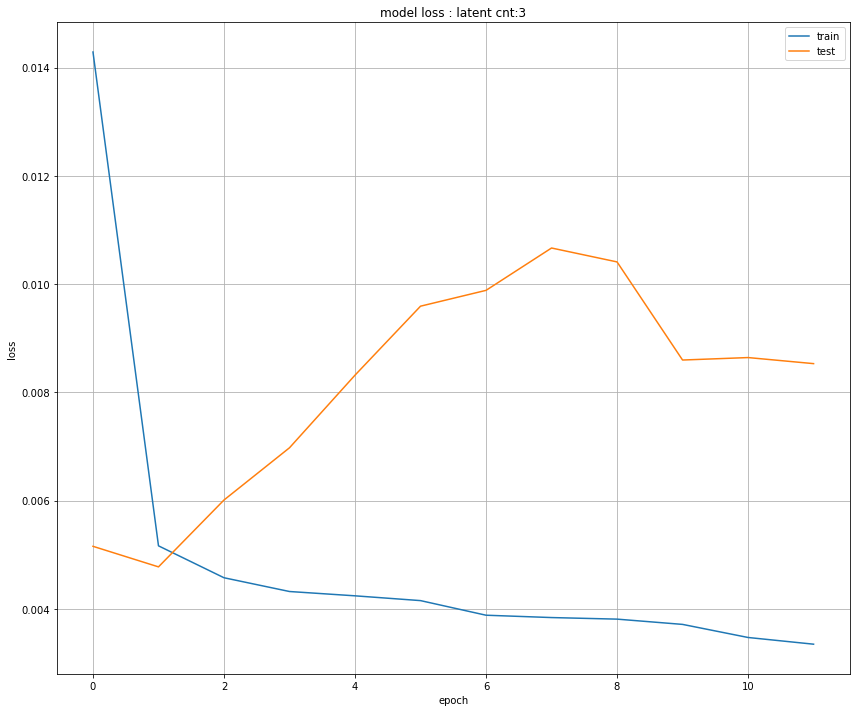

In [13]:
auto_hist = history.history
plt.figure()
plt.plot(auto_hist['loss'])
plt.plot(auto_hist['val_loss'])
plt.title(f'model loss : latent cnt:{latent_cnt}')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.tight_layout()
plt.grid()
plt.show()